In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import nbimporter
import seaborn as sns


In [3]:
#loading data from function made in main_code
from library import load_data

# Load data but do not store the output
data = load_data()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


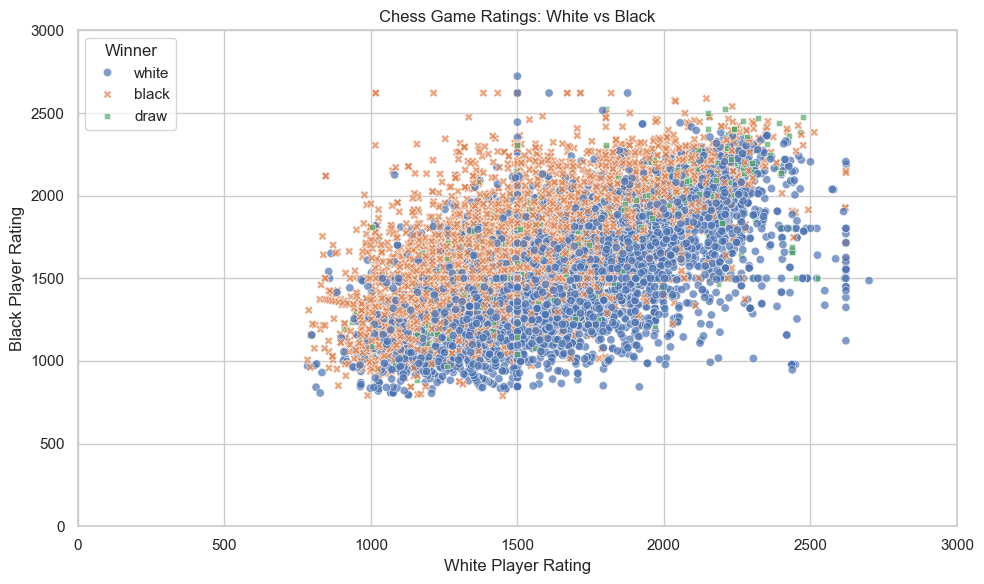

In [4]:
#lets plot the winner based on white elo and black elo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="white_rating", y="black_rating", hue="winner", style="winner", alpha=0.7)
plt.title("Chess Game Ratings: White vs Black")
plt.xlabel("White Player Rating")
plt.ylabel("Black Player Rating")
plt.legend(title="Winner", loc='upper left')
plt.xlim(0, 3000)
plt.ylim(0, 3000)
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\lopke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


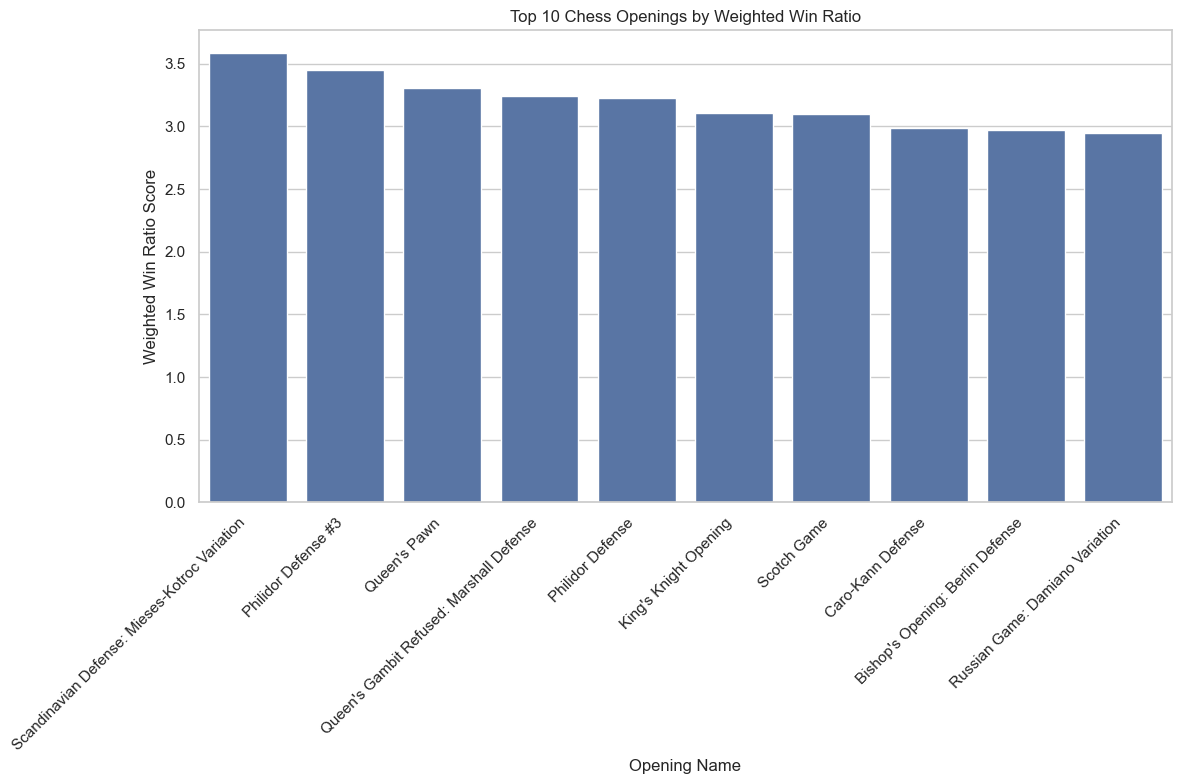

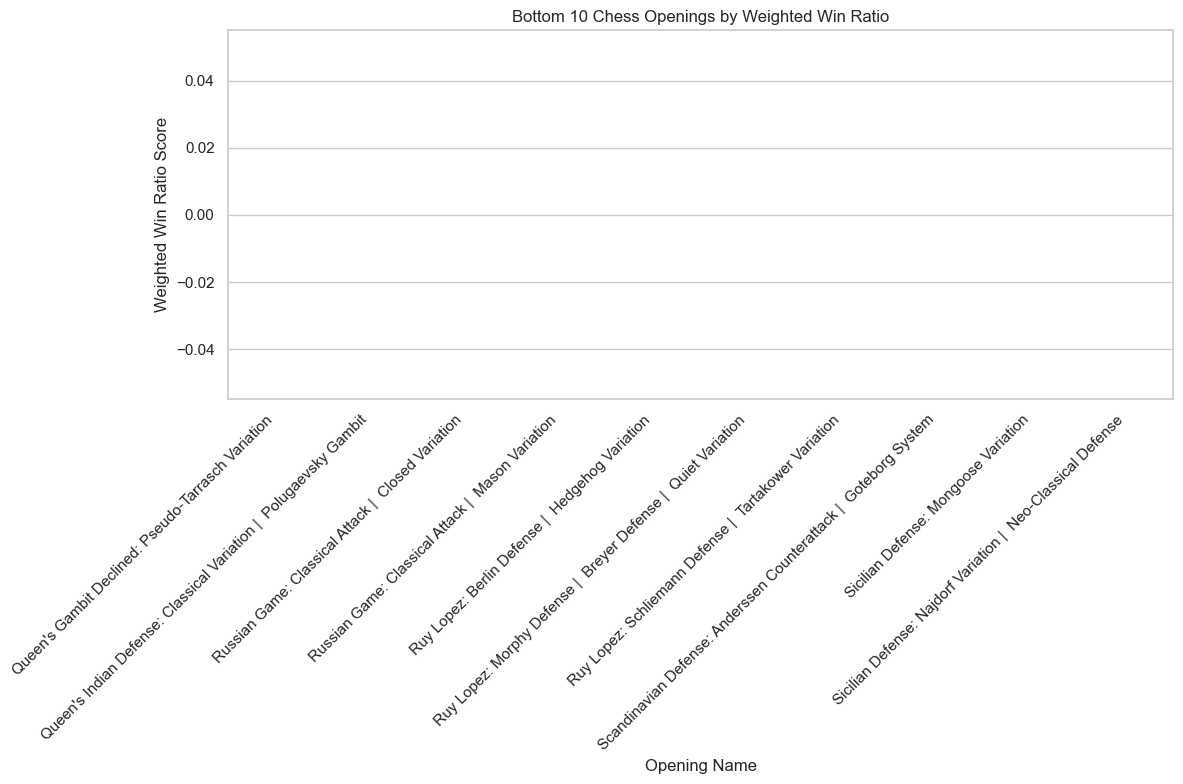

In [5]:
#lets check the win precentage of white and black players based on the opening name
data["opening_name"].unique()
winner_byopening = data.groupby("opening_name")["winner"].value_counts().unstack().fillna(0)

# lets add a ratio to not have a bias towards the opening with more games played
winner_byopening['ratio'] = winner_byopening['white'] / (winner_byopening['white'] + winner_byopening['black'])
winner_byopening.sort_values(by="ratio", ascending=False, inplace=True)
winner_byopening['games_played'] = winner_byopening['white'] + winner_byopening['black']
# lets make it only 100 games and up to remove bias towards openings with less games played
winner_byopening1 = winner_byopening[winner_byopening['games_played'] >= 100]

#now lets add weight to games played, so that it does not only display the ratio of wins, but also considers the number of games played for each opening
import numpy as np

winner_byopening['score'] = winner_byopening['ratio'] * np.log(winner_byopening['games_played'])
winner_byopening.sort_values(by='score', ascending=False, inplace=True)
winner_byopening

#lets plot the top 10 openings based on the score
plt.figure(figsize=(12, 8))
sns.barplot(x=winner_byopening['score'][:10].index, y=winner_byopening['score'][:10].values)
plt.title("Top 10 Chess Openings by Weighted Win Ratio")
plt.xlabel("Opening Name")
plt.ylabel("Weighted Win Ratio Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# now lets visualize the top 10 worst openings based on the score
plt.figure(figsize=(12, 8))
sns.barplot(x=winner_byopening['score'][-10:].index, y=winner_byopening['score'][-10:].values)
plt.title("Bottom 10 Chess Openings by Weighted Win Ratio")
plt.xlabel("Opening Name")
plt.ylabel("Weighted Win Ratio Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Average turns until mate: 65.57


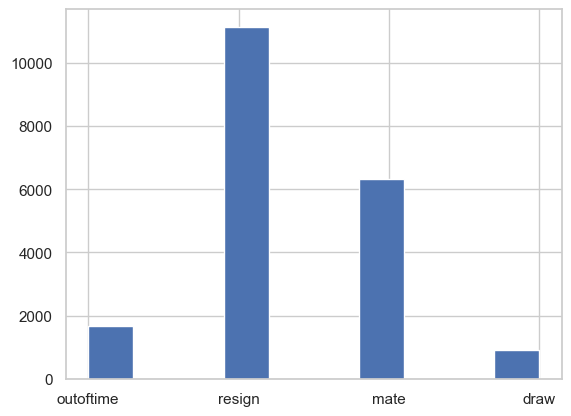

In [6]:
#check distribution of game lengths
plt.hist(data=data, x="victory_status")
only_mates = data[data["victory_status"] == "mate"]
avg_turns = only_mates.groupby("id")["turns"].max().mean()
avg_turns = round(avg_turns, 2)
print(f"Average turns until mate: {avg_turns}")

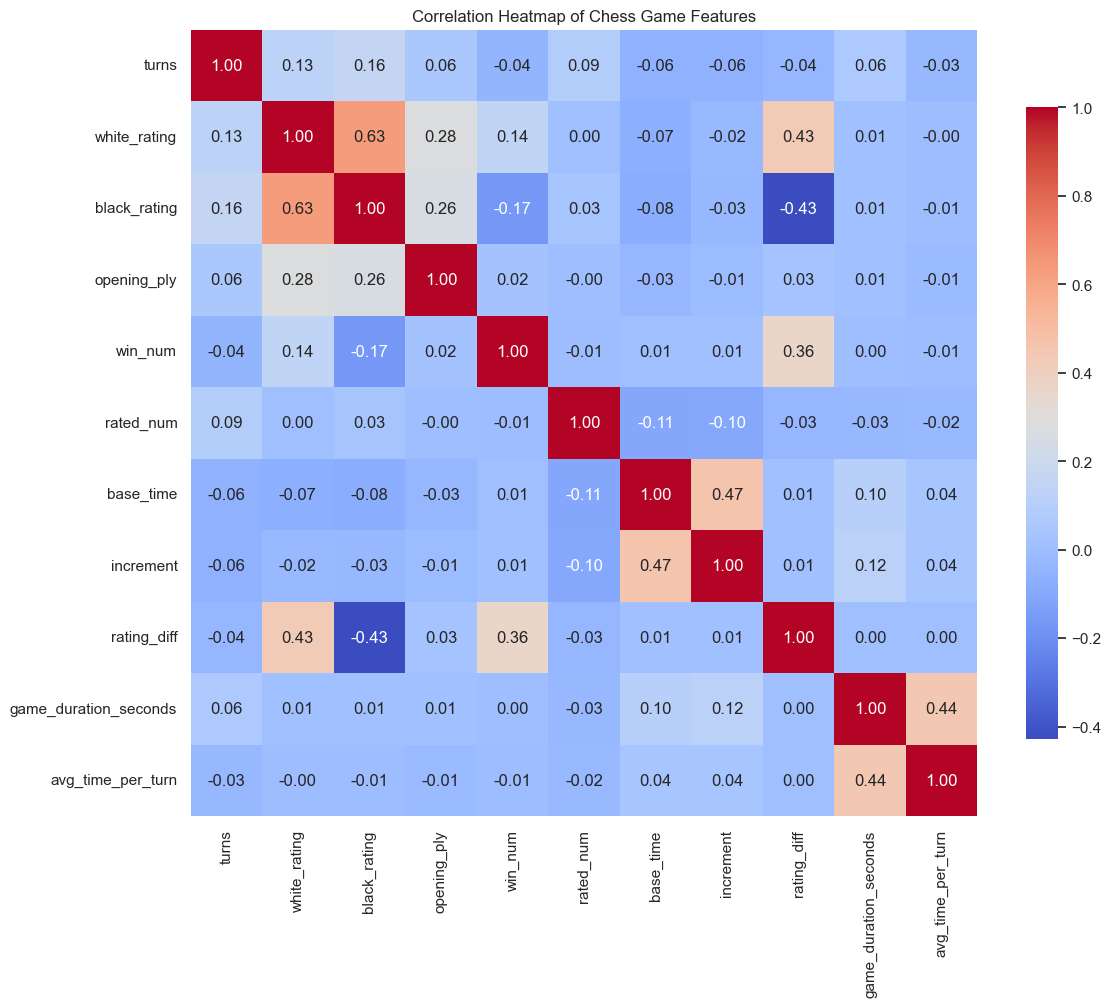

In [7]:
# Let's make a correlation map:
# First, preprocess the data
from library import preprocess_data
data1 = preprocess_data(data)
processed_data = data1.make_num(feature_engineering=True)
processed_data.head()
#Now let's plot the correlation map

corr = processed_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap of Chess Game Features")
plt.tight_layout()
plt.show()

#even with this low of corr, i will still make models. higher level models will be able to find patterns that are not visible in the correlation map.
# and since its chess anyway, having a highly accurate model is not the goal, but rather to find patterns that can be used to improve the game.


<Axes: xlabel='opening_name'>

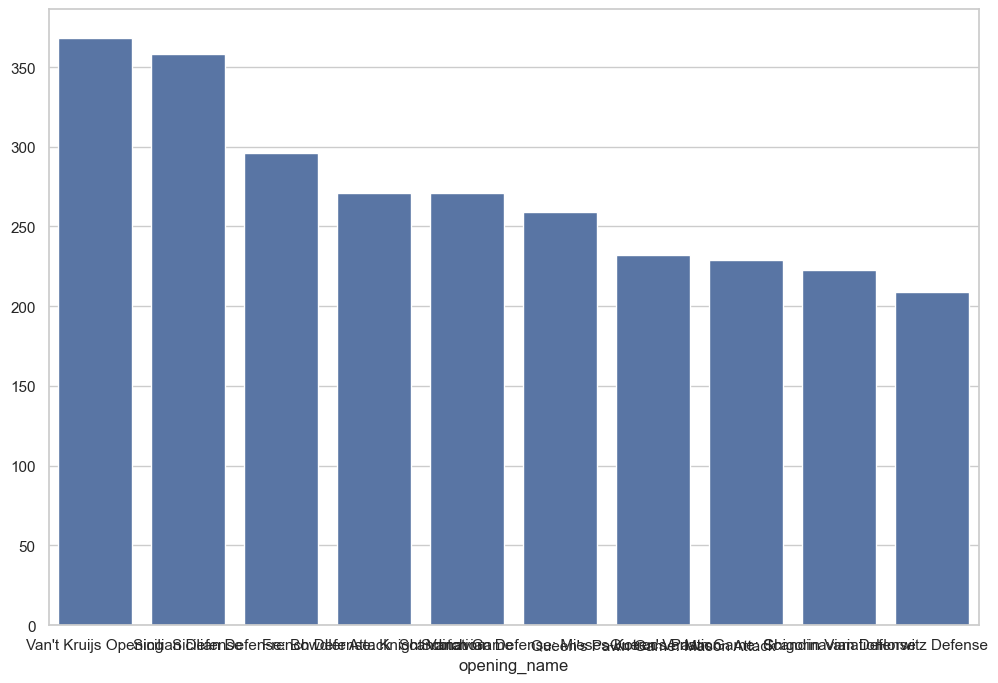

In [8]:
#analyze which openings get played most:
count_openings = data['opening_name'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=count_openings.index, y=count_openings.values)

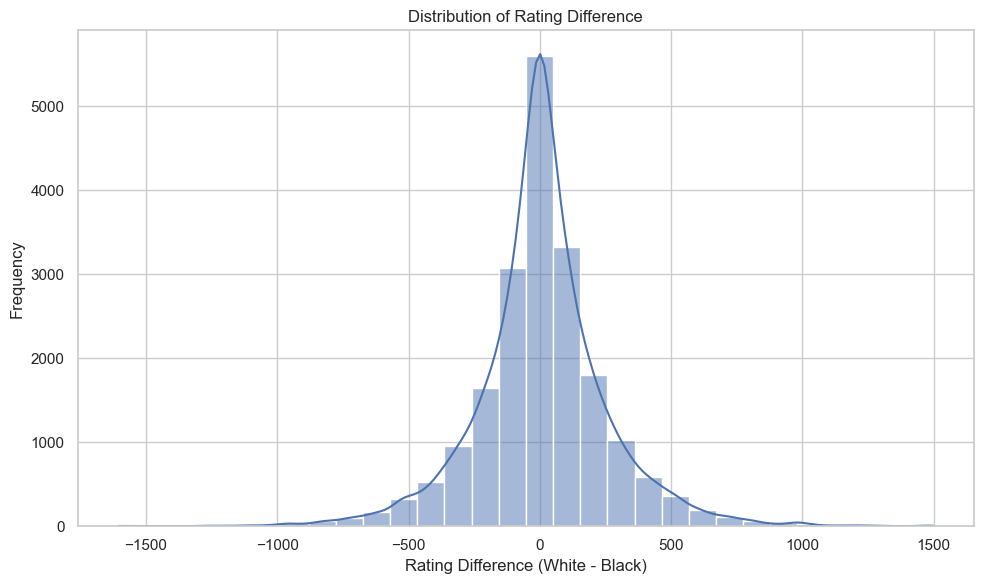

T-statistic: 0.9577334763282976, P-value: 4.068761562357913e-59


C:\Users\lopke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20058.
  res = hypotest_fun_out(*samples, **kwds)


In [9]:
#lets plot the dist of rating_diff.
plt.figure(figsize=(10, 6))
sns.histplot(data=processed_data, x="rating_diff", bins=30, kde=True)
plt.title("Distribution of Rating Difference")
plt.xlabel("Rating Difference (White - Black)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#lets calculate the t-test for the rating difference
from scipy import stats
t_stat, p_value = stats.shapiro(processed_data['rating_diff'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")

#p is insanely small, so we can reject the null hypothesis that the rating difference is not normally dist. 


In [10]:
# lets make a new column named rating_avg
processed_data['rating_avg'] = (processed_data['white_rating'] + processed_data['black_rating']) / 2
processed_data.mean()
#  1592.731927 avg rating. pretty high. 

turns                      60.465999
white_rating             1596.631868
black_rating             1588.831987
opening_ply                 4.816981
win_num                     0.522285
rated_num                   0.805414
base_time                  13.824110
increment                   5.249626
rating_diff                 7.799880
game_duration_seconds     869.707050
avg_time_per_turn          21.564553
rating_avg               1592.731927
dtype: float64

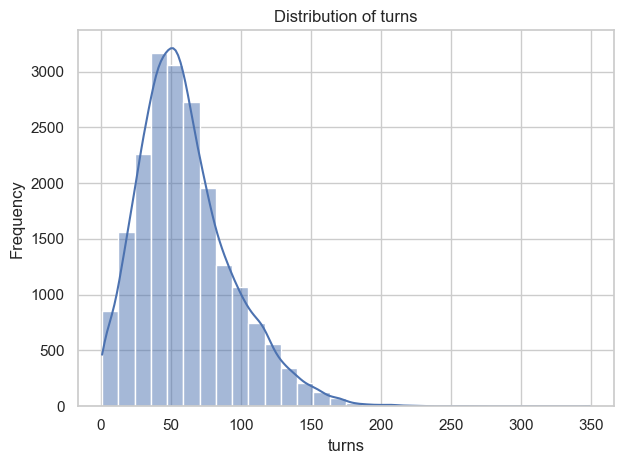

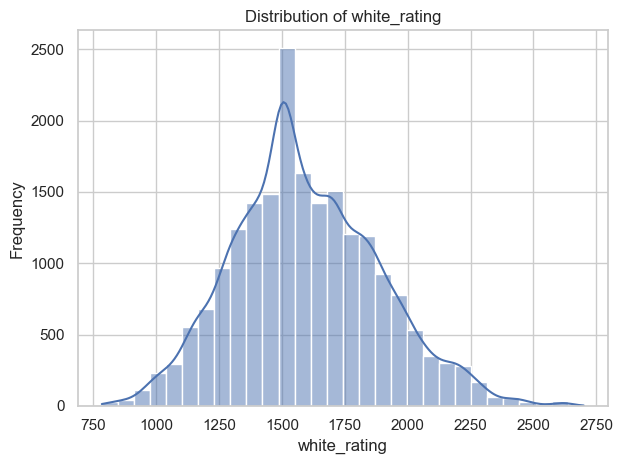

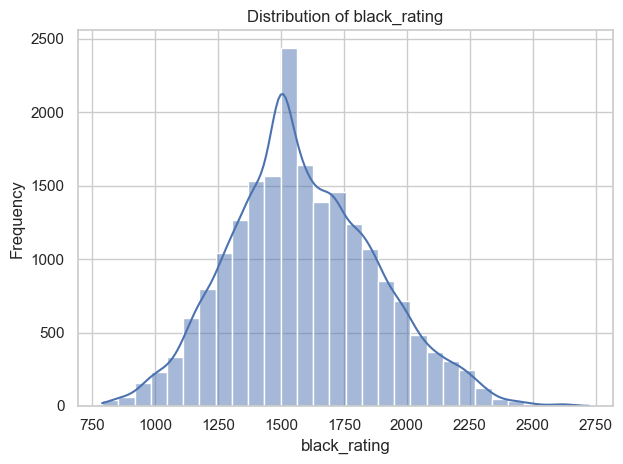

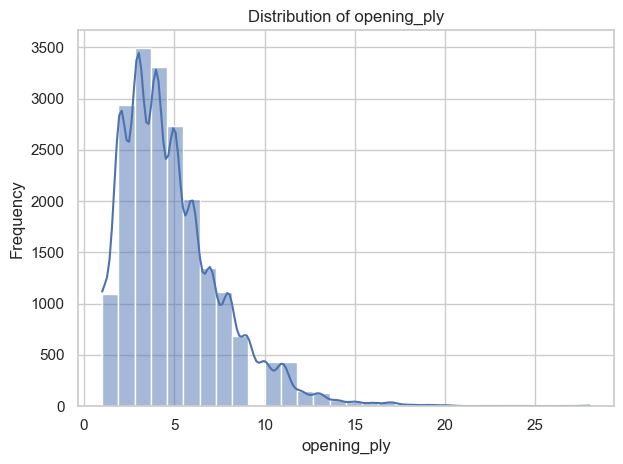

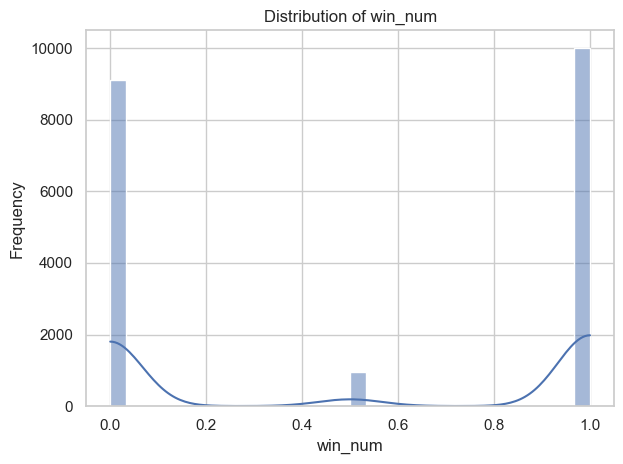

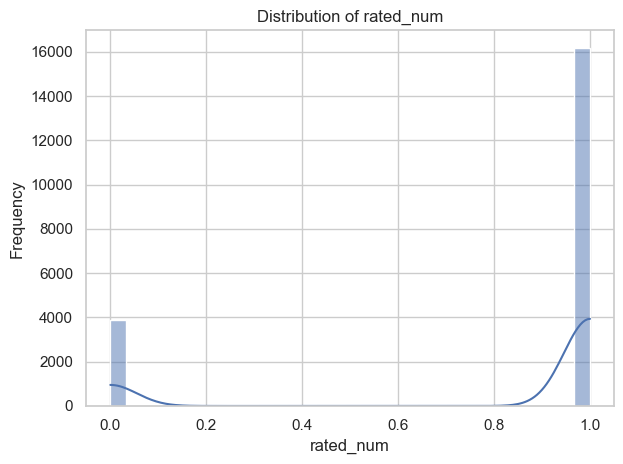

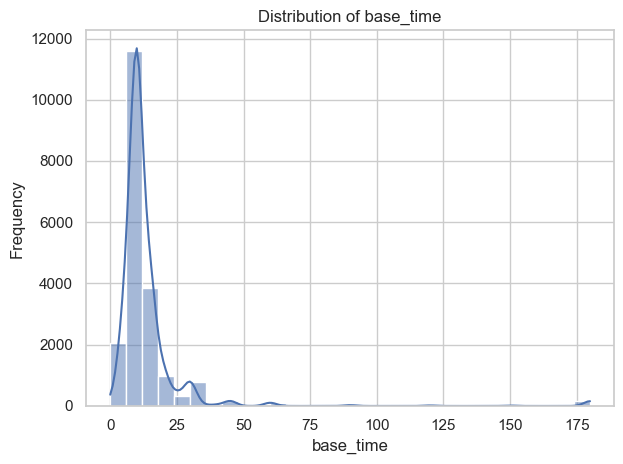

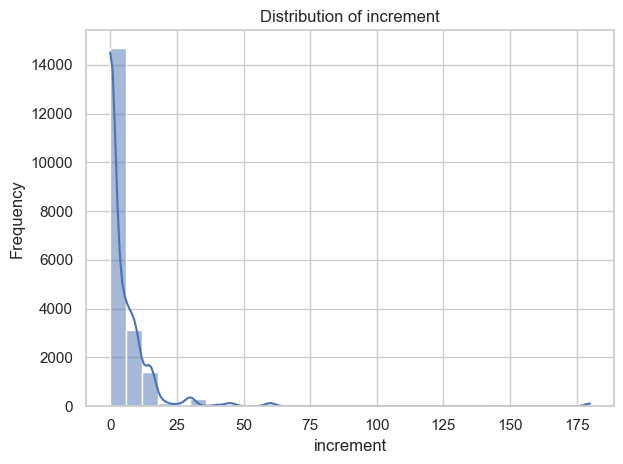

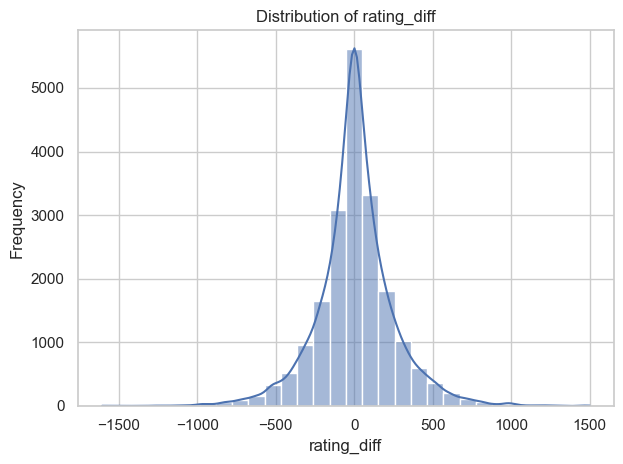

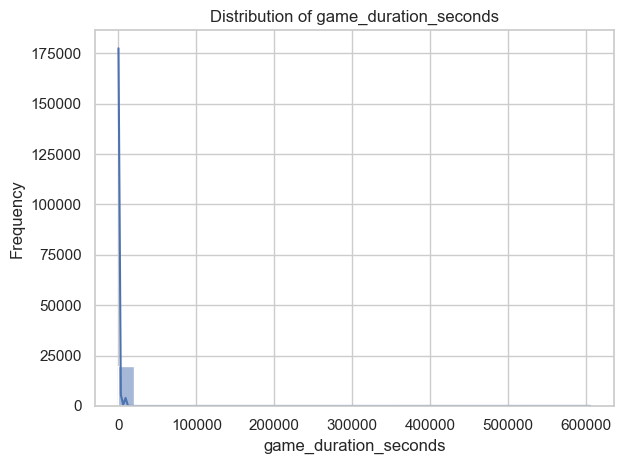

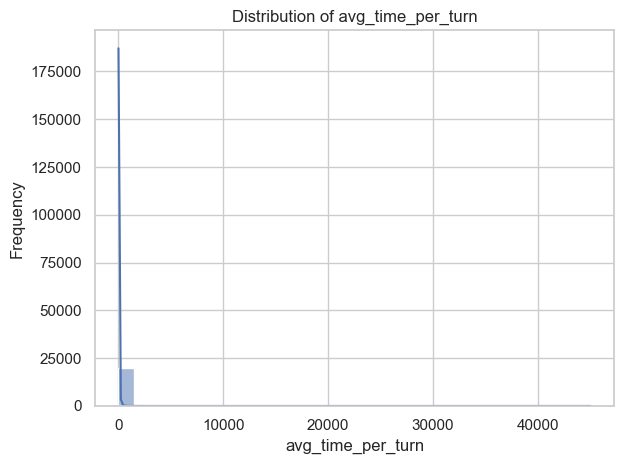

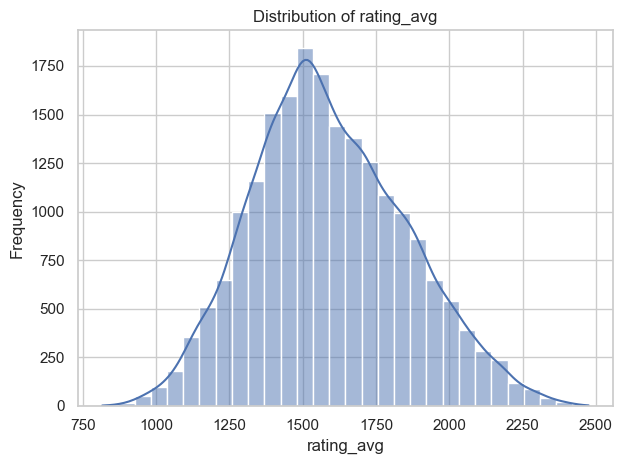

In [13]:
#lets so each columns distribution (numeric only first)
processed_data

def plot_distributions(data):
    for col in data.columns:
        sns.histplot(data[col], kde=True, bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

plot_distributions(processed_data)